In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams['savefig.dpi'] = 300

In [ ]:
model = "t5-3b"
task_to_times = {
    "news_sum": list(range(2012, 2017)),
    "news_cls": list(range(2012, 2017)),
    "wmt_lm": list(range(2012, 2017)),
    "poli_aff": list(range(2015, 2021)),
    "twitter_lm": list(range(2015, 2021)),
    "aic": ["2006-2008", "2009-2011", "2012-2014", "2015-2017", "2018-2020"],
    "arxiv_lm": ["2006-2008", "2009-2011", "2012-2014", "2015-2017", "2018-2020"]
}
t5_small_projs = np.load(f"./projections/{model}_time_vec_layer_projections.npy", allow_pickle=True).item()

for param, projs in t5_small_projs.items():
    #fig, axs = plt.subplots(1, len(projs), figsize=(len(projs), 1))
    #axs = axs.flatten()

    for i, (task, proj_pts) in enumerate(projs.items()):
        lines, = plt.plot(proj_pts[:, 0], proj_pts[:, 1], alpha=0.25)
        plt.scatter(proj_pts[:, 0], proj_pts[:, 1], label=task, s=8)
        for j in range(len(proj_pts)):
            plt.annotate(task_to_times[task][j], (proj_pts[j][0] + 0.04, proj_pts[j][1] + 0.04), fontsize=7)


    #plt.title(model + " Time Vector EncDecAtt_V Projection")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{model} " + param + " projections")
    plt.legend()
    plt.show()

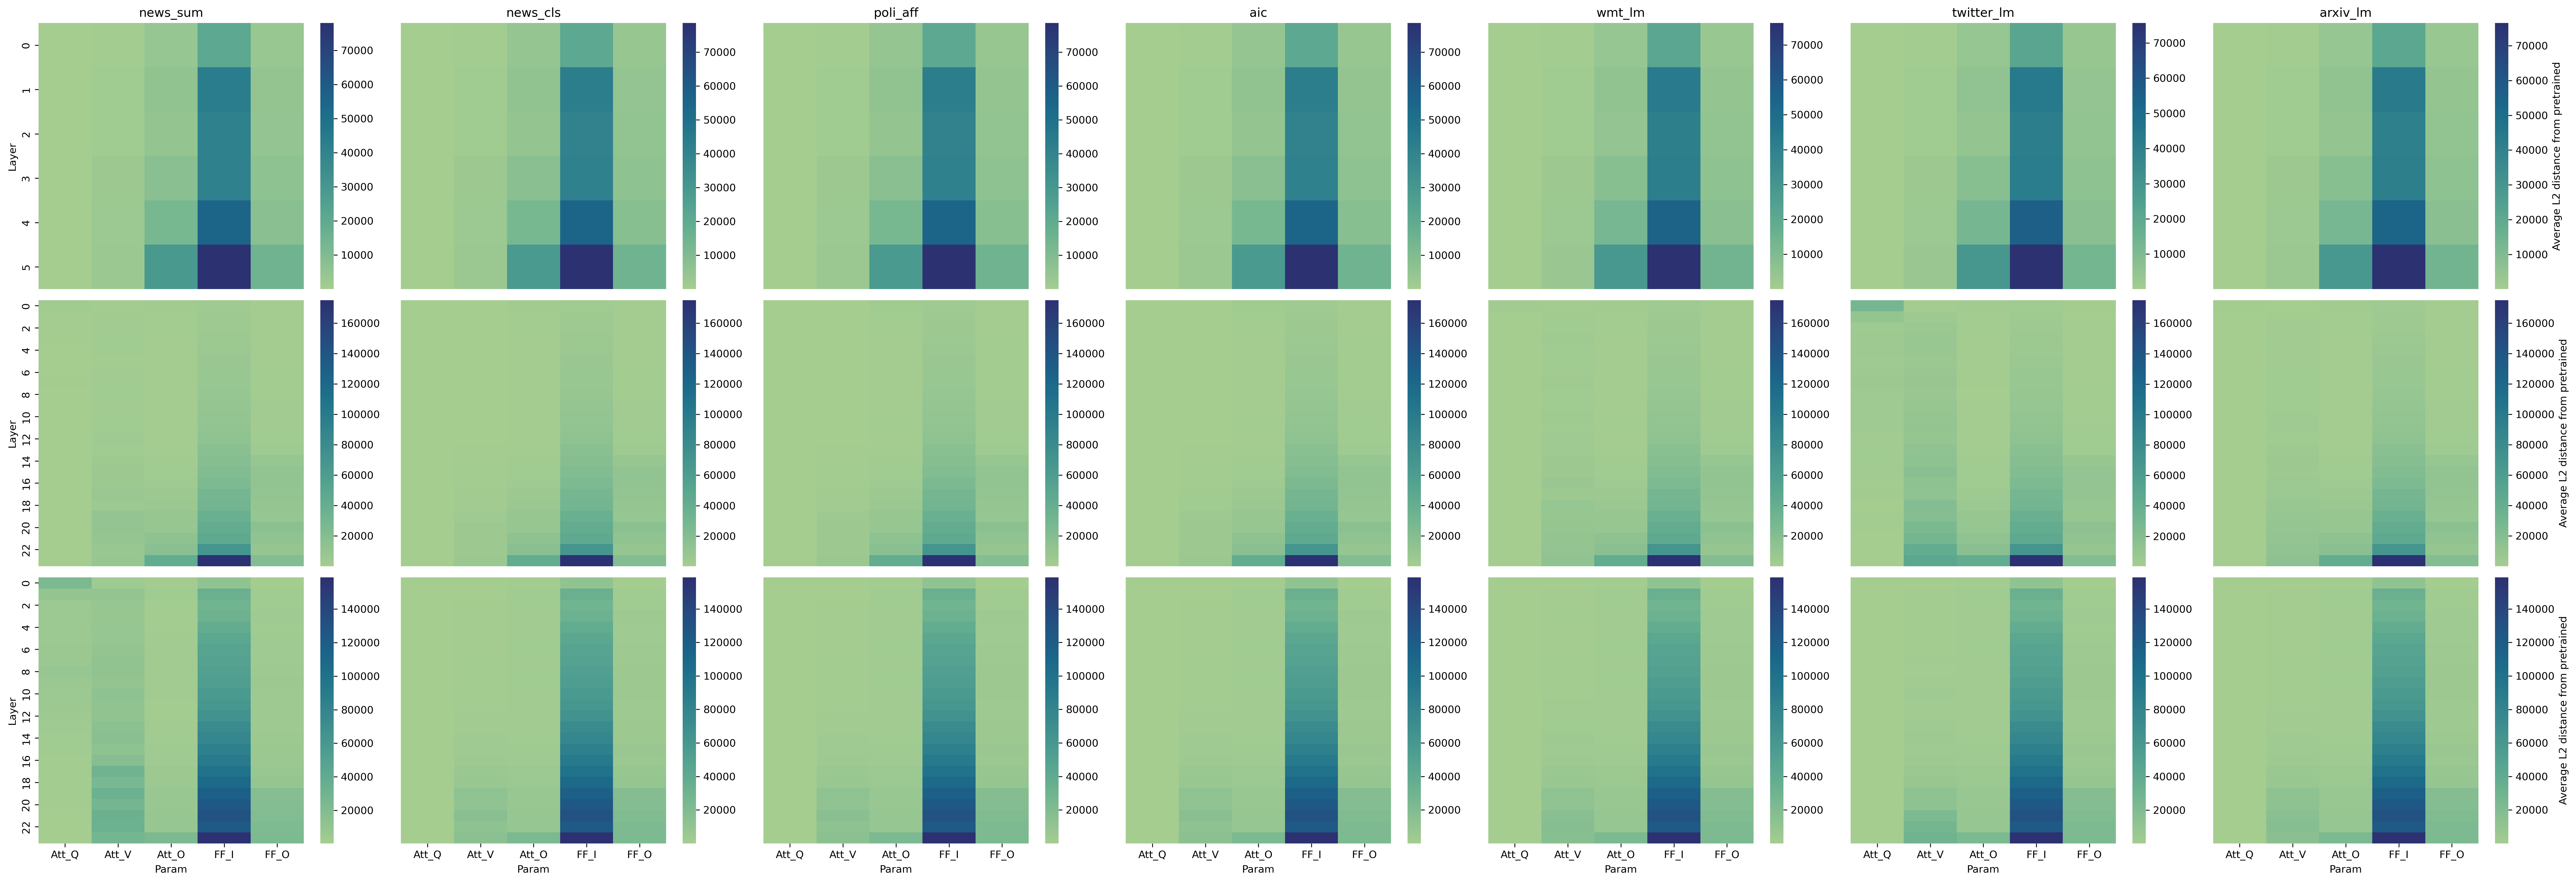

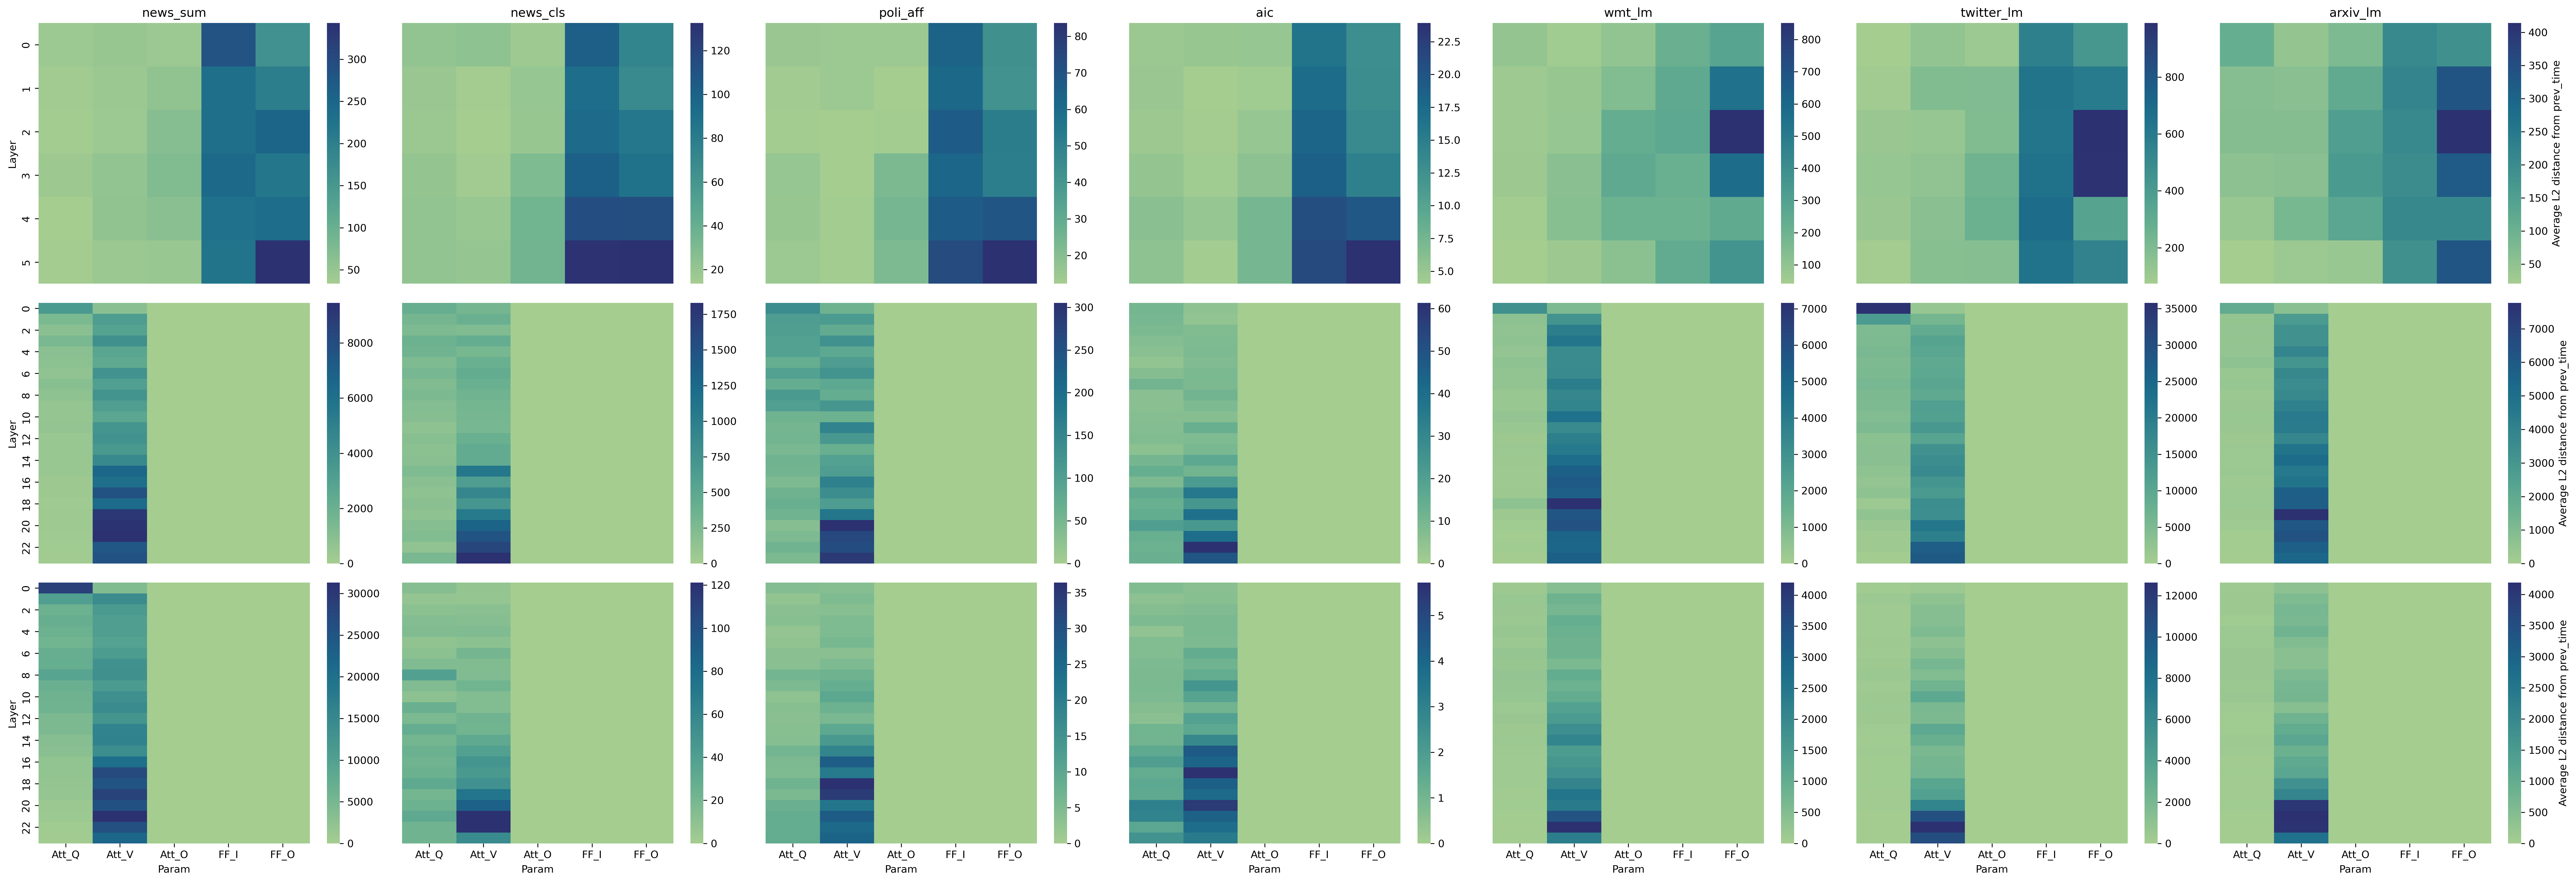

In [69]:
models = ["t5-small", "t5-large", "t5-3b"]
model_num_layers = [6, 24, 24]
num_tasks = 7

#dist_type = "prev_time" # "pretrained"

for dist_type in ["pretrained", "prev_time"]:

    fig, axs = plt.subplots(len(models), num_tasks, figsize=(num_tasks * 5, len(models) * 4))

    for m, model in enumerate(models):
        time_vec_distances = np.load(f"./projections/{model}_time_vec_distances.npy", allow_pickle=True).item()
        num_layers = model_num_layers[m]

        for i, task in enumerate(time_vec_distances[model].keys()):
            #print(list(param_dists.keys()))
            param_dists = time_vec_distances[model][task]
            time_params = []
            num_times = len(param_dists[f"shared.weight_{dist_type}_dist"])
            for t in range(num_times):
                ff_i = []
                ff_o = []
                att_q = []
                att_k = []
                att_v = []
                att_o = []
                for l in range(num_layers):
                    ff_i.append(param_dists[f"encoder.block.{l}.layer.1.DenseReluDense.wi.weight_{dist_type}_dist"][t])
                    ff_o.append(param_dists[f"encoder.block.{l}.layer.1.DenseReluDense.wo.weight_{dist_type}_dist"][t])
                    att_q.append(param_dists[f"encoder.block.{l}.layer.0.SelfAttention.q.weight_{dist_type}_dist"][t])
                    att_k.append(param_dists[f"encoder.block.{l}.layer.0.SelfAttention.k.weight_{dist_type}_dist"][t])
                    att_v.append(param_dists[f"encoder.block.{l}.layer.0.SelfAttention.v.weight_{dist_type}_dist"][t])
                    att_o.append(param_dists[f"encoder.block.{l}.layer.0.SelfAttention.o.weight_{dist_type}_dist"][t])

                #time_params.append([att_q, att_k, att_v, att_o, ff_i, ff_o])
                time_params.append([att_q, att_v, att_o, ff_i, ff_o])

            time_params = np.mean(time_params, axis=0)
            heatmap = sns.heatmap(time_params.T, ax=axs[m][i], cmap="crest")
            
            if i == 6:
                heatmap.collections[0].colorbar.set_label('Average L2 distance from ' + dist_type)
            if i == 0:
                axs[m][i].set_ylabel("Layer")
            else:
                axs[m][i].set_yticks([])
            if m == 0:
                axs[m][i].set_title(task)
            if m == 2:
                axs[m][i].set_xlabel("Param")
                #axs[m][i].set_xticklabels(["Att_Q", "Att_K", "Att_V", "Att_O", "FF_I", "FF_O"])
                axs[m][i].set_xticklabels(["Att_Q", "Att_V", "Att_O", "FF_I", "FF_O"])
            else:
                axs[m][i].set_xticks([])
            #ax.set_title(model + " " + task + " Average L2 Distance From " + dist_type)

    plt.tight_layout()
    plt.show()
